In [1]:
library("broom")
library("ggpubr")
library("ggplot2")
library("tidyverse")

Loading required package: ggplot2

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.2.1     ✔ dplyr   1.1.4
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 1.0.0
✔ purrr   1.0.2     
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
basefolder = "~/Documents/moroni/capre/delower"
outdir = file.path(basefolder, "paper")

In [3]:
####################################
## F:B RATIO
####################################
fname = file.path(basefolder, "Analysis/results/taxa_abundance_results_goat_milk.RData")
load(fname)
names(to_save)

[1] "phylum_relabund"         "data_for_fb"            
[3] "fb_res"                  "relabund_for_lm"        
[5] "genus_stats"             "significant_genus_stats"
[7] "contrasts"

In [4]:
dta = to_save$data_for_fb
fb = to_save$fb_res

In [5]:
fb <- fb |>
  mutate(invFB = 1/FB)

In [6]:
head(fb)

sample,treatment,timepoint,Bacteroidetes,Firmicutes,FB,invFB
<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
sample-1,Treated,T1,0.000000,95.95202,Inf,0.00000000
sample-10,Not treated,T1,7.760532,60.97561,7.857143,0.12727273
sample-100,Not treated,T3,39.426523,792.11470,20.090909,0.04977376
sample-101,Treated,T3,558.011050,1230.20258,2.204620,0.45359281
sample-102,Not treated,T3,1418.502203,4112.33480,2.899068,0.34493840
sample-103,Not treated,T3,112.648221,472.33202,4.192982,0.23849372


## does the FB data have heavy tails?

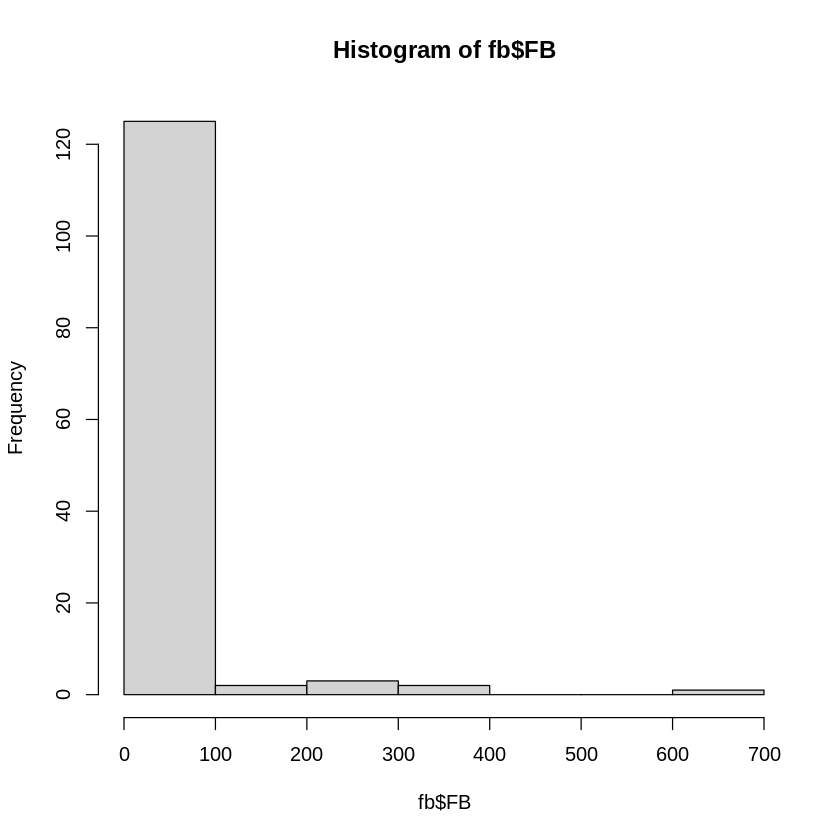

In [7]:

hist(fb$FB)

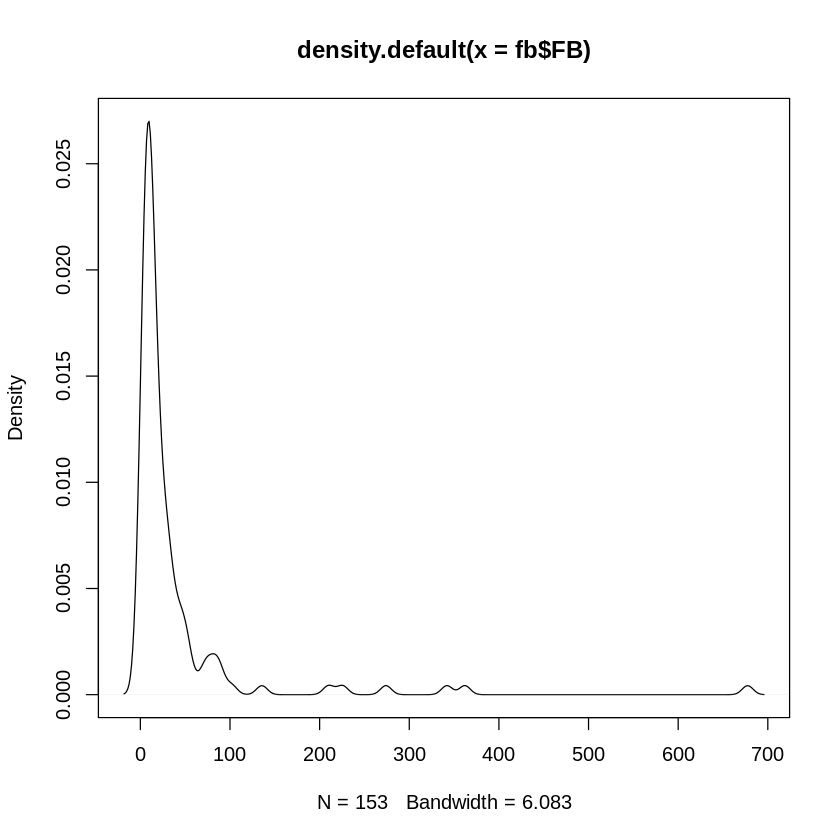

In [8]:
plot(density(fb$FB))

We can look at skewness and kurtosis:

<u>skewness</u>
- $0$: gaussian; 
- $< 0$: mean $<$ median (left-skew)
- $> 0$: mean $>$ median (right-skew)

<u>kurtosis</u>
- $0$: gaussian; 
- $< 0$: platykurtic (thin tails)
- $> 0$: leptokurtic (fat tails)

You can also look at MAD/SD:

- MAD: mean absolute deviation
- SD: standard deviation
- MAD/SD ratio as a gauge of fat-tailedness
- MAD/SD close to zero --> fat the tails; MAD/SD close to 1 --> thin tails 
- normal distribution has a MAD/SD ratio of 0.797 (square root of 2 over pi)

from: https://david-salazar.github.io/posts/fat-vs-thin-tails/2020-05-13-standard-deviation-and-fat-tails.html

and from: https://www.r-bloggers.com/2012/10/how-fat-are-your-tails/

and from: https://www.iaeng.org/publication/WCE2012/WCE2012_pp324-329.pdf

and from: https://arxiv.org/abs/2001.10488

In [9]:
vec <- !is.infinite(fb$FB)
temp <- fb[vec,]

In [10]:
library("e1071")
temp |>
  ungroup() |>
  dplyr::summarise(skewness = skewness(FB), ## 0: gaussian; < 0 : mean < median (left-skew); > 0: mean > median (right-skew)
                   kurtosis = kurtosis(FB), ## 0: gaussian; < 0: platykurtic (thin tails); > 0: leptokurtic (fat tails)
                   std = sd(FB, na.rm=TRUE), 
                   mad = mean(abs(FB-mean(FB))), 
                   mad_sd = mad/std)

skewness,kurtosis,std,mad,mad_sd
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5.299117,33.92354,79.2647,37.50807,0.4732003


In [11]:
temp |>
  group_by(timepoint) |>
  dplyr::summarise(skewness = skewness(FB), ## 0: gaussian; < 0 : mean < median (left-skew); > 0: mean > median (right-skew)
                   kurtosis = kurtosis(FB), ## 0: gaussian; < 0: platykurtic (thin tails); > 0: leptokurtic (fat tails)
                   std = sd(FB, na.rm=TRUE), 
                   mad = mean(abs(FB-mean(FB))), 
                   mad_sd = mad/std)

timepoint,skewness,kurtosis,std,mad,mad_sd
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
T1,4.654310,23.85164,53.54015,25.89661,0.4836857
T2,3.109114,10.41627,130.43769,77.38268,0.5932540
T3,3.329110,12.77684,22.84697,13.20227,0.5778564


In [12]:
library("heavy")

temp <- fb |>
    filter(!is.infinite(FB))

fit <- heavyLm(FB ~ timepoint + treatment, data = temp, family = Cauchy())
summary(fit)

Linear model under heavy-tailed distributions
 Data: temp; Family: Cauchy() 

Residuals:
    Min      1Q  Median      3Q     Max 
-16.752  -4.474   2.262  16.811 660.252 

Coefficients:
                      Estimate Std.Error Z value p-value
(Intercept)          14.3557   1.9107    7.5133  0.0000
timepointT2           3.7479   2.4339    1.5399  0.1236
timepointT3          -5.3001   2.2210   -2.3863  0.0170
treatmentNot treated -0.8561   1.8726   -0.4571  0.6476

Degrees of freedom: 133 total; 129 residual
Scale estimate: 58.25649
Log-likelihood: -610.1381 on 5 degrees of freedom

In [13]:
fit_reduced <- heavyLm(FB ~ timepoint, data = temp, family = Cauchy())
summary(fit_reduced)

Linear model under heavy-tailed distributions
 Data: temp; Family: Cauchy() 

Residuals:
    Min      1Q  Median      3Q     Max 
-16.913  -4.199   2.423  17.368 660.091 

Coefficients:
             Estimate Std.Error Z value p-value
(Intercept) 13.7988   1.6535    8.3452  0.0000
timepointT2  3.6097   2.4161    1.4940  0.1352
timepointT3 -5.2686   2.2047   -2.3898  0.0169

Degrees of freedom: 133 total; 130 residual
Scale estimate: 57.41605
Log-likelihood: -610.2285 on 4 degrees of freedom

#### Likelihood ratio test for the treatment effect

In [18]:
loglik_full = fit$logLik
loglik_reduced = fit_reduced$logLik

In [19]:
LR = -2*(loglik_reduced - loglik_full)

In [20]:
## LR is distributed as chi-square random variable with 1 df (1 parameter difference between full and reduced models)
(p.val <- pchisq(LR, df = 1, lower.tail = FALSE))

[1] 0.6706822

#### Likelihood ratio test for the timepoint effect

In [24]:
fit_reduced <- heavyLm(FB ~ treatment, data = temp, family = Cauchy())
summary(fit_reduced)

Linear model under heavy-tailed distributions
 Data: temp; Family: Cauchy() 

Residuals:
    Min      1Q  Median      3Q     Max 
-11.965  -3.851   1.737  20.487 666.237 

Coefficients:
                      Estimate Std.Error Z value p-value
(Intercept)          11.9655   1.3692    8.7393  0.0000
treatmentNot treated -0.7023   1.9148   -0.3668  0.7138

Degrees of freedom: 133 total; 131 residual
Scale estimate: 60.92475
Log-likelihood: -616.6559 on 3 degrees of freedom

In [25]:
loglik_full = fit$logLik
loglik_reduced = fit_reduced$logLik

LR = -2*(loglik_reduced - loglik_full)

(p.val <- pchisq(LR, df = 1, lower.tail = FALSE))

[1] 1.801277e-184

#### Cauchy regression for treatment by timepoint

In [23]:
temp <- fb |> filter(!is.infinite(FB))

for (step in unique(temp$timepoint)) {
    
    print(step)
    dat = filter(temp, timepoint == step)
    fit <- heavyLm(FB ~ treatment, data = dat, family = Cauchy())
    print(summary(fit))
}

[1] "T1"
Linear model under heavy-tailed distributions
 Data: dat; Family: Cauchy() 

Residuals:
    Min      1Q  Median      3Q     Max 
-16.849  -4.127   1.391  16.443 329.131 

Coefficients:
                      Estimate Std.Error Z value p-value
(Intercept)          16.8486   2.6139    6.4459  0.0000
treatmentNot treated -3.9798   3.6966   -1.0766  0.2816

Degrees of freedom: 42 total; 40 residual
Scale estimate: 71.7391
Log-likelihood: -190.675 on 3 degrees of freedom
[1] "T3"
Linear model under heavy-tailed distributions
 Data: dat; Family: Cauchy() 

Residuals:
    Min      1Q  Median      3Q     Max 
 -7.924  -2.464   1.043   9.852 126.626 

Coefficients:
                      Estimate Std.Error Z value p-value
(Intercept)          6.3269   1.1500    5.5017  0.0000 
treatmentNot treated 2.6299   1.5970    1.6468  0.0996 

Degrees of freedom: 54 total; 52 residual
Scale estimate: 17.19227
Log-likelihood: -210.1663 on 3 degrees of freedom
[1] "T2"
Linear model under heavy-tailed

#### Plotting FB

Warning message in geom_boxplot(aes(color = treatment), alpha = 1/10, outliers = FALSE):
“Ignoring unknown parameters: `outliers`”


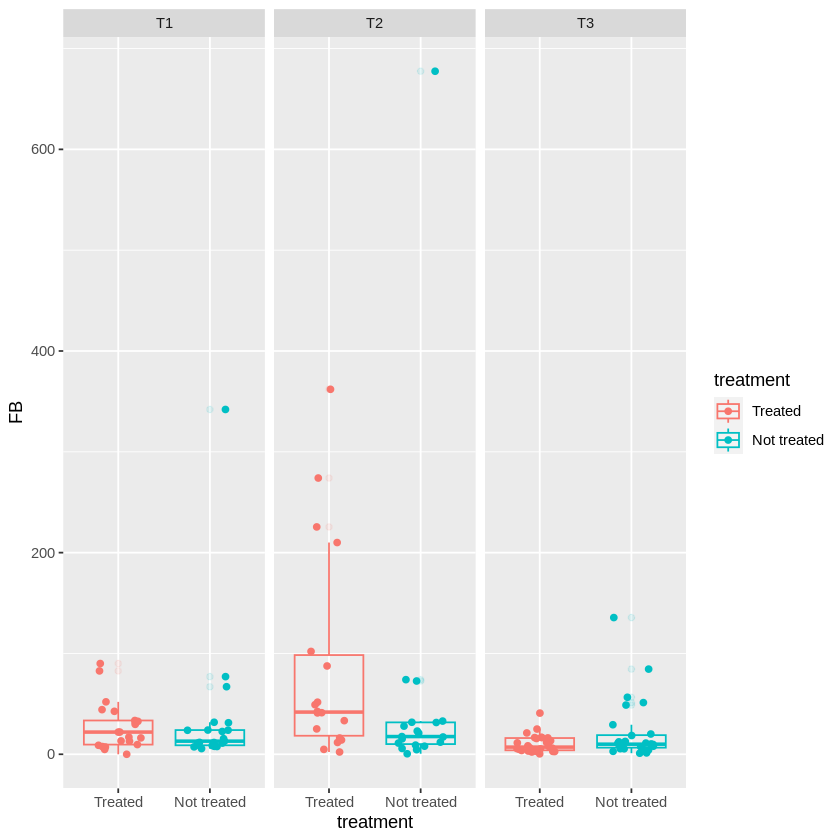

In [26]:
p1 <- ggplot(filter(fb, FB != Inf), aes(x = treatment, y = FB)) 
p1 <- p1 + geom_boxplot(aes(color = treatment), alpha = 1/10, outliers = FALSE)
p1 <- p1 + geom_jitter(aes(color=treatment), width = 0.25)
p1 <- p1 + facet_wrap(~timepoint)
p1

#### Benchmark gaussian linear regression model by timepoint 

In [27]:
temp <- filter(fb, FB != Inf) |>
  group_by(timepoint) |>
  do(tidy(lm(FB ~ treatment, data = .))) |>
  filter(term != "(Intercept)") |>
  mutate(term = gsub('treatment','',term)) |>
  rename(treatment = term) |>
  select(timepoint, treatment, p.value)

In [28]:
temp

timepoint,treatment,p.value
<chr>,<chr>,<dbl>
T1,Not treated,0.60372710
T2,Not treated,0.47738870
T3,Not treated,0.08183304


## power regression

Many processes do not follow the *Gaussian distribution*:

*"80% of all effects results from 20% of all causes"* (Pareto)

For example, 20% of all people own 80% of all wealth.
These heavy tailed distributions had been used to describe the number of papers published by scientists, sizes of cities and word frequency (Keller 2005 "Revisiting ‘Scale-Free’ Networks.").

- Barabási and Réka 1999 (Science): the distribution of hyperlinks in the web follows a power law distribution (connectivity of web pages, $k$, decreased with rate $k \alpha$)
- Albert, Jeong, and Barabási 1999 (Nature): "scale-free" phenomena (e.g. casualty numbers in armed conflicts, the occurrence of unique words in the novel Moby Dick etc.) 

There are two basic types of **power law distributions**:

1. discrete
2. continuous

In [85]:
library("poweRlaw")


Attaching package: ‘poweRlaw’


The following object is masked from ‘package:broom’:

    bootstrap


